# Network Identifiability

Here we use a measure of network modularity `Q` obtained via Louvain's heuristic for partitioning a graph structure. 

Like in Ciric (2017) we will:

- [x] Use a signed variant of the Louvain algorithm to allow for negative edges
- [x] Not threshold our data (see note)

We'll be using $\tau=0$ as with the Louvain method lower values of $\tau$ provide [better partitions](https://static-content.springer.com/esm/art%3A10.1038%2Fsrep00336/MediaObjects/41598_2012_BFsrep00336_MOESM1_ESM.pdf):

In [128]:
import os
import re

from multiprocessing import Pool

import numpy as np
import pandas as pd

import bct

In [100]:
SUB_REGEX = re.compile("sub-[A-Za-z0-9]+")
SES_REGEX = re.compile("ses-[A-Za-z0-9]+")
TASK_REGEX = re.compile("task-[A-Za-z0-9]+")
RUN_REGEX = re.compile("run-[A-Za-z0-9]+")
DESC_REGEX = re.compile("desc-[A-Za-z0-9]+")
MATCH_ENTITIES = [
    'sub','ses','task','run'
    ]

In [147]:
scratch = "/scratch/jjeyachandra/multiband-censoring-comparisons/"
subject_csvs = [
    f"{scratch}/output/{f}"
    for f in
    os.listdir(os.path.join(scratch, "output"))
    if "sub-" in f and f.endswith("tsv")
]

## Part 1: Preprocessing

Here we compute modularity $Q$

In [105]:
def load_and_transform(csv):
    df = pd.read_csv(csv, sep="\t").set_index("row")
    remove_indices = df.index.str.contains("\?\?\?")
    remove_cols = df.columns.str.contains("\?\?\?")
    return ex.drop(ex.index[remove_indices])\
            .drop(ex.columns[remove_indices], axis=1)\
            .to_numpy()

In [141]:
def compute_CI(G, num_opt=100):
    '''
    Compute a [V x C] matrix where:
    V - indicates a particular vertex
    C - indicates the community assignment of a vertex
    
    Arguments:
        G - Symmetric Graph to compute on
        num_opt - Number of Louvain optimizations to perform
    '''
    
    CI = np.empty((G.shape[0], num_opt))
    Qs = np.empty((num_opt))
    for i in range(num_opt):
        P, Q = bct.modularity_louvain_und_sign(G)
        CI[:, i] = P
        Qs[i] = Q
    return CI, Qs.mean()

In [145]:
def compute_subject_Q(csv):
    _, Q = compute_CI(load_and_transform(csv))
    return Q

In [176]:
def split_entities(x):
    '''
    Given a BIDS string x, construct entities
    '''
    
    def get_reg(reg, x):
        res = reg.search(x)
        return res[0] if res else np.nan
    
    sub_entities = (
        ("sub", get_reg(SUB_REGEX, x)),
        ("ses", get_reg(SES_REGEX, x)),
        ("task",get_reg(TASK_REGEX, x)),
        ("run",get_reg(RUN_REGEX, x)),
        ("desc",get_reg(DESC_REGEX, x))
    )
    
    res = {}
    for k,v in sub_entities:
        res[k] = v 
    return res

In [177]:
# Run if not computed yet
f_modularity = "../../data/output/modularity.parquet"
if not os.path.exists(f_modularity):
    with Pool(30) as pool:
        qs = pool.map(compute_subject_Q, subject_csvs)
    rows = []
    for s, q in zip(subject_csvs, qs):

        res = split_entities(os.path.basename(s))
        res['Q'] = q
        rows.append(res)

    qdf = pd.DataFrame.from_dict(rows)
    qdf.to_parquet(f_modularity)
else:
    qdf = pd.read_parquet(f_modularity)

## Part 2: Analysis

In [214]:
import scipy.stats as scistats

Load in the FD dataframe

In [193]:
def extract_entities(row):
    entities = split_entities(row.entity)
    for k,v in entities.items():
        row[k] = v
    return row

In [199]:
f_fd = f"{scratch}/output/meanFD.csv"
fd = pd.read_csv(f_fd)\
        .apply(extract_entities, axis=1)\
        .dropna(axis=1)

Compute Q-FD correlations

In [204]:
FILTERS = {
    'ses': 'ses-01',
    'task': 'task-rest',
    'run': 'run-1'
}

In [209]:
def filter_df(df, filters=FILTERS):
    df_masks = np.logical_and.reduce(np.array([
                df[k] == v for k,v in filters.items()
            ]), axis=0)
    df = df.iloc[df_masks, :]
    return df

In [212]:
df = filter_df(qdf).merge(fd, how='left',
                         left_on=MATCH_ENTITIES,
                         right_on=MATCH_ENTITIES)

In [219]:
results = []
for m, g in df.groupby('desc'):
    r, p = scistats.pearsonr(g['mean_fd'], g['Q'])
    res = {
        'pearson': r,
        'pvalue': p,
        'method': m
    }
    results.append(res)
result_df = pd.DataFrame.from_dict(results)

## Part 3: Visualization

In [221]:
import plotnine as pn

In [252]:
viz_Q = df.groupby('desc').mean().reset_index()

In [253]:
viz_Q

,desc,Q,mean_fd
0,desc-base,0.611620,0.275511
1,desc-dct,0.611598,0.239371
2,desc-fourier,0.611599,0.239031
3,desc-lindquistpowers,0.611627,0.239371
4,desc-powers,0.611621,0.235572


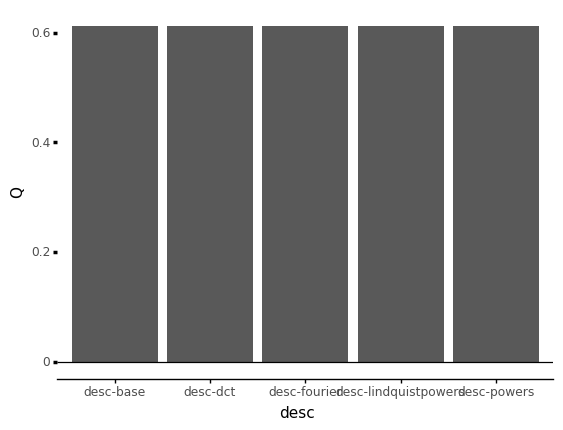

<ggplot: (8730048891655)>

In [256]:
(pn.ggplot(viz_Q, pn.aes(x='desc',
                        y='Q'))
    + pn.geom_col()
    + pn.geom_hline(yintercept=0)
    + pn.theme(
        panel_background=pn.element_rect(fill='white'),
        axis_line_x=pn.element_line(color='black'),
        axis_ticks_major_y=pn.element_line(color='black',size=2.5)
    )
)

In [238]:
# Add significance star
viz_df = result_df
viz_df["sig"] = viz_df['pvalue']\
                    .apply(lambda x: "*" if x < 0.05 else '')

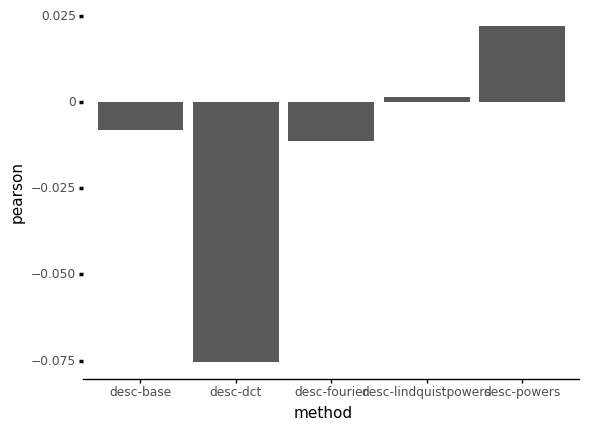

<ggplot: (8730049410557)>

In [239]:
(pn.ggplot(viz_df, pn.aes(x='method', y='pearson'))
    + pn.geom_col()
    + pn.geom_text(pn.aes(label='sig'),
                size=15, va='bottom')
    + pn.theme(
        panel_background=pn.element_rect(fill='white'),
        axis_line_x=pn.element_line(color='black'),
        axis_ticks_major_y=pn.element_line(color='black',size=2.5)
    )
)  